In [1]:
#Funções de risco e de retorno de carteiras
portfolio_sd_t <- function(pesos, cov){
  sd_t <- sqrt(t(as.matrix(pesos)) %*% cov %*% as.matrix(pesos))
  return(sd_t)
}
portfolio_return <- function(returns, weight){
  if(!is.vector(returns)){
    mean <- apply(returns,2,mean, na.rm = T)
  } else{
    if(is.vector(returns)){
      mean <- returns
    }
  }
  total_return <- sum(weight*mean)
  return(total_return)
}

In [2]:
#Função de pesos de carteiras
pesos_carteira <- function(n_acoes, n_sim, short = F){
  pesos <- matrix(0,n_acoes,n_sim)
  if(isFALSE(short)){
    pesos <- apply(pesos,2,rexp,0.001)
  }else{
    pesos <- apply(pesos,2,rnorm)
    
  }
  pesos <- apply(pesos,2,function(x)x/sum(x))
  colsub <- apply(pesos,2,function(x)!any(x >= 1| x <= -1))
  pesos <- pesos[,colsub]
  return(pesos)
}

In [3]:
options(warn = -1, scipen = 999)
pacotes <- c("dplyr", "tidyr","ggplot2","tidyquant","pracma","rmgarch","rugarch","car")
for(i in pacotes){
    suppressPackageStartupMessages({
        library(i, character.only = T)
    })
}

In [4]:
#Ações escolhidas
acoes <- c("MGLU3.SA","PETR4.SA","PRIO3.SA","WEGE3.SA","VVAR3.SA","TRPL4.SA")
reta <- tq_get(acoes, from = "2013-01-04") %>%
  group_by(symbol) %>%
  tq_transmute(select = adjusted, mutate_fun = dailyReturn) %>%
  spread(key = symbol, value = daily.returns) %>%
  na.omit

In [5]:
#Pegando o ano, mês e dia da primeira observação
year <- lubridate::year(dplyr::first(reta$date))
month <- lubridate::month(dplyr::first(reta$date))
day <- lubridate::day(dplyr::first(reta$date))

In [6]:
#Transformando em série temporal
reta_ts <- ts(reta[,2:ncol(reta)], start = c(year,month,day), frequency = 252)

In [7]:
multspec <- multispec(replicate(length(acoes),
                                ugarchspec()))
multf <- multifit(multispec = multspec, data = reta_ts)
multfor <- multiforecast(multf, n.ahead = 2)
spec1 <- dccspec(uspec = multspec, dccOrder = c(1,1), distribution = "mvnorm")
fit1 <- dccfit(spec1, data = reta_ts, fit = multf, fit.control = list(eval.se = T))
fore <- dccforecast(fit = fit1, n.ahead = 2)

In [8]:
#Matriz de covariância
cov1 <- rcov(fit1)
cov <- cov1[,,dim(cov1)[3]]
cov_f <- rcov(fore)
cov_f <- cov_f[[1]]
cov_f1 <- cov_f[1:length(acoes),1:length(acoes),1]
cov_f2 <- cov_f[1:length(acoes),1:length(acoes),2]

In [9]:
#Desvio das ações
sd <- sqrt(diag(cov))
sd_f1 <- sqrt(diag(cov_f1))
sd_f2 <- sqrt(diag(cov_f2))
sd_a <- sd*sqrt(252)
sd_a_f1 <- sd_f1*sqrt(252)
sd_a_f2 <- sd_f2*sqrt(252)

In [10]:
#Retorno médio das ações
retornos_a <- tq_get(acoes, from = Sys.Date()-365*5) %>%
  group_by(symbol) %>%
  tq_transmute(select = close, mutate_fun= periodReturn, period = "yearly", fill = 0) %>%
  mutate(year = year(date)) %>%
  group_by(year,symbol) %>%
  summarise(yearly.returns) %>%
  spread(key = "symbol", value = "yearly.returns") %>%
  na.fill(fill = 0)

`summarise()` regrouping output by 'year' (override with `.groups` argument)



In [11]:
retorno_med <- retornos_a %>%
  data.frame %>%
  gather(key = "symbol", value = "return", -year) %>%
  group_by(symbol) %>%
  summarise(media = mean(return)) %>%
  spread(key = "symbol", value = "media") %>%
  as.matrix() %>%
  t() %>%
  as.data.frame() %>%
  mutate(Riscos = sd_a_f2)
colnames(retorno_med) <- c("Retorno","Risco")
rownames(retorno_med) <- sort(acoes)
retorno_med$Retorno <- c(1.0177, 0.23444,0.8,0.15199, 0.61, 0.41549)

`summarise()` ungrouping output (override with `.groups` argument)



In [12]:
#Nº de simulações de carteiras a se fazer
n_sim <- 200000
pesos <- pesos_carteira(n_acoes = length(acoes), n_sim = n_sim, short = F)

In [13]:
#Escolha se prefere o risco atual ou a previsão de risco para 1 período (sd ou sd_f)
start <- Sys.time()
riscos <- apply(pesos, 2, portfolio_sd_t, cov = cov_f2)*sqrt(252)
riscos <- riscos %>% as.matrix
retornos <- apply(pesos, 2, portfolio_return, returns = retorno_med$Retorno) %>% as.matrix
colsub <- apply(riscos,1,function(x)!is.nan(x))
riscos <- riscos[colsub]
retornos <- retornos[colsub]
end <- Sys.time()
end-start

Time difference of 14.97803 secs

In [14]:
#Sharpe
tx_livre_risco <- 0.02
data <- matrix(0, nrow = 3, ncol = length(riscos))
data[1,] <- retornos
data[2,] <- riscos
data[3,] <- (retornos-tx_livre_risco)/riscos
rownames(data) <- c("Retornos", "Riscos","Sharpe")
pesos <- pesos[,colsub]
d <- data[2,which(data[1,] <= max(data[1,]))]
data_t <- t(data) %>%
  as.data.frame() %>%
  mutate(Riscos = round(Riscos,3)) %>%
  filter(Riscos < d) %>%
  group_by(Riscos) %>%
  summarise(Retornos = max(Retornos))
data_d <- as.data.frame(t(data))

`summarise()` ungrouping output (override with `.groups` argument)



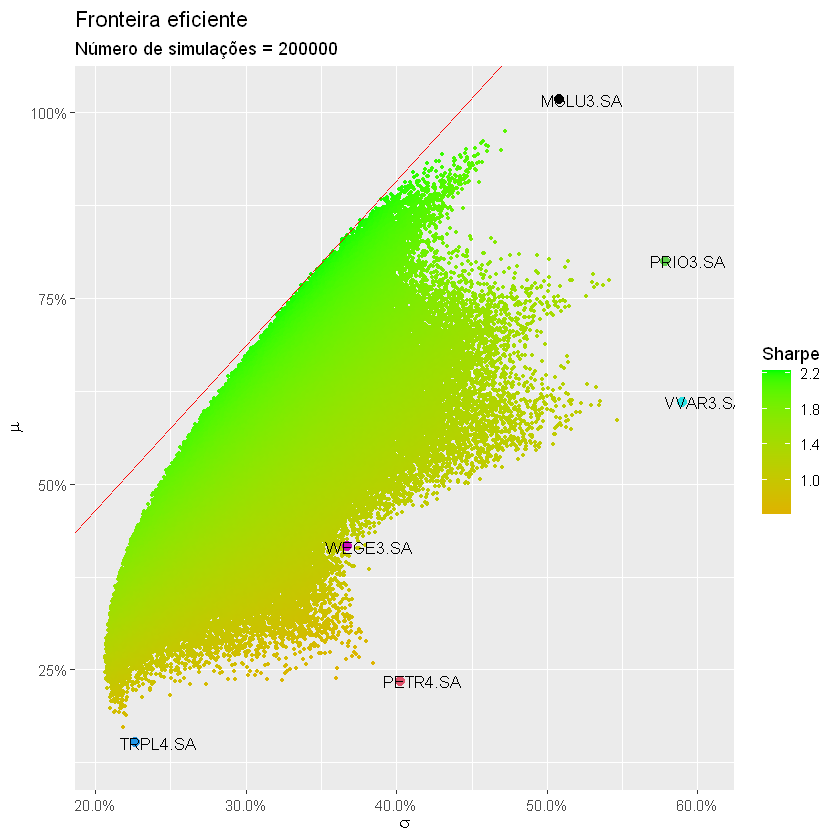

In [15]:
ggplot()+
  geom_point(data = data_d, mapping = aes(x = Riscos, y = Retornos, col = Sharpe), size = 0.8)+
  geom_point(data = retorno_med, aes(x = Risco, Retorno), col = 1:nrow(retorno_med), size = 2.5)+
  geom_text(data = retorno_med, aes(x = Risco+0.015, Retorno, label = sort(acoes)),
            size = 3.5)+
  geom_abline(slope = max(data[3,]), intercept = tx_livre_risco, col = "red")+
  scale_colour_gradient2(low = "red", high = "green", mid = "darkorange")+
  labs(x = expression(sigma), y = expression(mu), title = "Fronteira eficiente",
       subtitle = paste("Número de simulações =",ncol(pesos)))+
  geom_hline(yintercept = 0, lty = 2)+
  geom_vline(xintercept = 0, lty = 2)+
  scale_y_continuous(labels = scales::percent, limits = c(min(retorno_med$Retorno)-0.02, max(retorno_med$Retorno)))+
  scale_x_continuous(labels = scales::percent, limits = c(min(riscos), max(sd_a_f2)+0.015))

In [16]:
sharpe <- max(data[3,])
names(sharpe) <- "Sharpe Máximo"
Ret_max <- max(data[1,])
names(Ret_max) <- "Retorno Máximo"
sd_min <- min(data[2,])
names(sd_min) <- "Risco Mínimo"
sharpe
Ret_max
sd_min

Sharpe Máximo 
     2.223357

Retorno Máximo 
     0.9748237

Risco Mínimo 
   0.2064436

In [17]:
#Somente ver a linha que tem o maior sharpe
positivo <- data[3,] == sharpe
show(data[,positivo])

 Retornos    Riscos    Sharpe 
0.8429185 0.3701243 2.2233571 


In [18]:
#Pesos em % da melhor carteira
pesos_efi <- round(pesos[,positivo],3)
names(pesos_efi) <- sort(acoes)
print(pesos_efi)

MGLU3.SA PETR4.SA PRIO3.SA TRPL4.SA VVAR3.SA WEGE3.SA 
   0.558    0.005    0.235    0.005    0.017    0.181 


In [19]:
#Carteira eficiente com arredondamento de 3 casas decimais
pesos_ef <- round(pesos[,positivo],3)
risco_ef <- portfolio_sd_t(cov = cov_f2, pesos= pesos_ef)*sqrt(252)
ret_ef <- portfolio_return(returns = retorno_med$Retorno, weight = pesos_ef)
cart_ef <- data.frame(Risco = risco_ef, Retorno = ret_ef, Sharpe = (ret_ef-tx_livre_risco)/risco_ef)
cart_ef

Risco,Retorno,Sharpe
<dbl>,<dbl>,<dbl>
0.3703481,0.8433824,2.223266


In [38]:
p <- c(0.553,0,0.296,0,0.02,0.131)*(101664-336)
print(pesos_efi*(101664)-p)

 MGLU3.SA  PETR4.SA  PRIO3.SA  TRPL4.SA  VVAR3.SA  WEGE3.SA 
  592.464     0.000 -8236.992  2643.264 -1823.232  7160.496 


In [28]:
sort(acoes)

[1] "MGLU3.SA" "PETR4.SA" "PRIO3.SA" "TRPL4.SA" "VVAR3.SA" "WEGE3.SA"

In [39]:
sum(p)

[1] 101328